In [48]:
using LinearAlgebra
using Plots
import QuantumToolbox
using HierarchicalEOM
import Plots
using LaTeXStrings
using LinearSolve # to change the solver for better GPU performance
using CUDA
CUDA.allowscalar(false)



In [57]:
# Parameter
Td = 0
λ = 0.1       # Badkopplungsstärke

ω0 = 1.0      # Eigenfrequenz 
dt = 0.01     # Zeitschritt
σm = sigmam() ## σ-
σz = sigmaz() ## σz
II = qeye(2)  ## identity matrix
λ = 0.1          # Reorganisationsenergie
kT=0.1
γ=0.4        #cuttof 

β = 1/kT ## Inverse Temperatur (1/kT)
tier = 4
N =10   #  Anzahl Matsubarafrequenzen

10

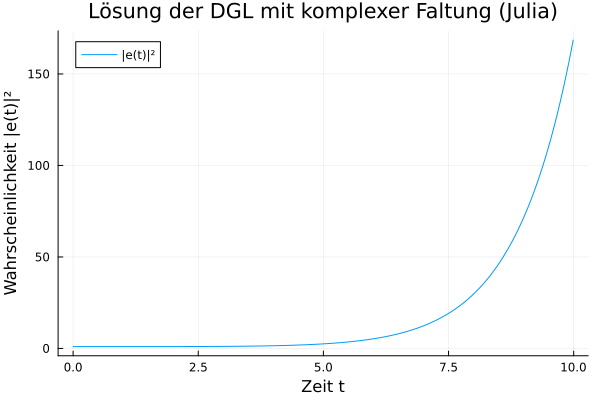

In [50]:
using SpecialFunctions
time = 0:dt:10-dt  # Zeitachse
P_e = zeros(ComplexF64, length(time))  # Wahrscheinlichkeit des angeregten Zustands
P_e[1] = 1.0  # Anfangswahrscheinlichkeit

# Korrelationsfunktion C(t)= int_0^inf J(w)*(cosh(β.. *Cos(w*t)-i*sin(w*t)))dw
function C(t)
    if t >= 0
        return -0.5 *1im * γ * λ * ( 2 * cosh(t * γ) * (1 + cosh(Td * γ)) +cosh((t - Td) * γ) * (floor((π - 2 * angle(t - Td)) / (4 * π)) -floor(0.75 + angle(t - Td) / (2 * π))))
    else
        return 0.0
    end
end
"""function C(t)
    return (1 / π) * γ * λ * (
        -2im * exp(-t * γ) * π +
        (exp(-t * γ) + exp(t * γ)) * coshint(t * γ) +
        sqrt(π) * meijerg([[0], []], [[0, 0], [1/2]], (t^2 * γ^2) / 4) -
        1im * exp(-γ * abs(t - Td)) * π * sign.(t - Td) -
        1im * exp(-(t + Td) * γ) * π * sign.(t + Td) +
        exp(-t * γ) * sinhint(t * γ) -
        exp(t * γ) * sinhint(t * γ)
    )
end"""

# Diskretisiere die Korrelationsfunktion
C_vals = [C(t) for t in time]

# Numerische Lösung der DGL
for k in 2:length(time)
    # Berechnung der Faltung
    convolution = sum(C_vals[1:k] .* P_e[k:-1:1]) * dt
    # Update von P_e[k]
    P_e[k] = P_e[k-1]   - dt  * convolution
end

# Plot der Lösung
plot(time, abs2.(P_e), label="|e(t)|²", xlabel="Zeit t", ylabel="Wahrscheinlichkeit |e(t)|²",
    title="Lösung der DGL mit komplexer Faltung (Julia)", grid=true)

In [51]:

H0 =  0.5*ω0 * σz

# Define the operator that measures the 0, 1 element of density matrix
ρ01 = Qobj([0 1; 0 0])

ψ0 = (basis(2, 0) + basis(2, 1)) / √1;

P00 = ket2dm(basis(2, 0))
P11 = ket2dm(basis(2, 1))
op=sigmax()

Quantum Object:   type=Operator   dims=[2]   size=(2, 2)   ishermitian=true
2×2 SparseMatrixCSC{ComplexF64, Int64} with 2 stored entries:
     ⋅      1.0+0.0im
 1.0+0.0im      ⋅    

Preparing block matrices for HEOM Liouvillian superoperator (using 1 threads)...
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 00s (ETA: 0h 00m 00s)
Constructing matrix...[DONE]
Solving time evolution for ADOs by Ordinary Differential Equations method...


┌ Warning: The value of approximation discrepancy δ is 0.0 now, which doesn't make any changes.
└ @ HierarchicalEOM /home/sander/.julia/packages/HierarchicalEOM/q1a1V/src/heom_matrices/heom_matrix_base.jl:367


Progress: [=========                     ]  30.6% --- Elapsed Time: 0h 07m 06s (ETA: 0h 16m 05s)

┌ Warning: Interrupted. Larger maxiters is needed. If you are using an integrator for non-stiff ODEs or an automatic switching algorithm (the default), you may want to consider using a method for stiff equations. See the solver pages for more details (e.g. https://docs.sciml.ai/DiffEqDocs/stable/solvers/ode_solve/#Stiff-Problems).
└ @ SciMLBase /home/sander/.julia/packages/SciMLBase/ZyZAV/src/integrator_interface.jl:589
GKS: glyph missing from current font: 178
GKS: glyph missing from current font: 178
GKS: glyph missing from current font: 178
GKS: glyph missing from current font: 178
GKS: glyph missing from current font: 178
GKS: glyph missing from current font: 178


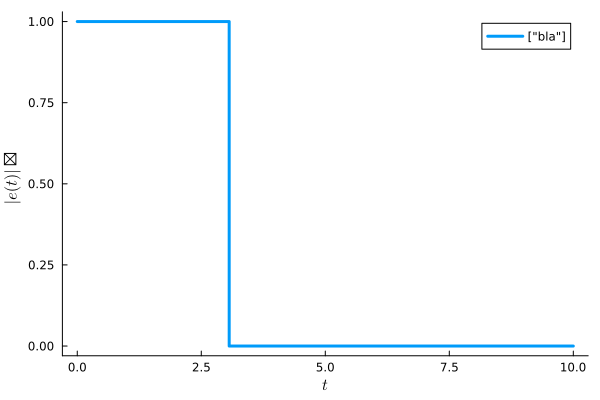

In [56]:
function boson_drude_lorentz_approx_discrepancy(λ,γ,kT,N,c,ν) 
    δ = 2 * λ * kT / γ - 1.0im * λ
    for k in 1:(N+1)
        δ -= c[k] / ν[k]
    end
    return δ
end

Td=0.4


function Boson_DrudeLorentz_Matsubara_self(op, λ, W, kT, N)
    
    β = 1.0 / kT
    ϵ = HierarchicalEOM.matsubara(N, fermion = false)
    
    c = ComplexF64[cosh(γ * Td/2)^2*λ*γ*(cot(γ * β / 2.0)-1.0im)]
    ν= ComplexF64[γ]
    
    if N > 0
        for l in 2:(N+1)
            
            append!(c,cosh(ϵ[l] * Td/2)^2* 4 * λ * γ * ϵ[l] * (kT^2) / (((ϵ[l] * kT)^2) - γ^2))
            append!(ν, ϵ[l] * kT)
        end
        end
    
    #δ =boson_drude_lorentz_approx_discrepancy(λ, γ, kT, N, c, ν)
    
    return HierarchicalEOM.BosonBath(op, c ,ν)
end


bath=Boson_DrudeLorentz_Matsubara_self(op, λ, ω0, kT, N)

#M = M_Boson(H0, tier, bath)
M_even_cpu = M_Boson(H0, tier, bath)
M_even_cpu =addTerminator(M_even_cpu,bath) #with same coupling as λ?
M_even_gpu = cu(M_even_cpu)
tlist = 0:0.0004:10
result = HEOMsolve(M_even_gpu, ψ0, tlist; e_ops = [ ρ01]);

Plots.plot(
    tlist,
    [ abs2.(result.expect[1, :])],
    label = ["bla"],
    #linestyle = [:solid :dot :dash],
    linewidth = 3,
    xlabel = L"t",
    ylabel = L"|e(t)|²",
    grid = false,
)


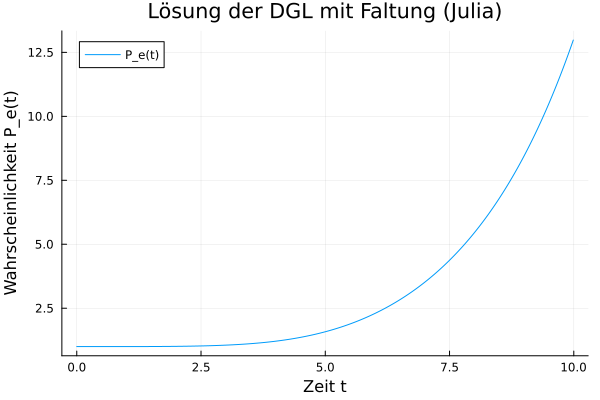

In [53]:
Plots.plot(time, abs.(P_e), label="P_e(t)", xlabel="Zeit t", ylabel="Wahrscheinlichkeit P_e(t)", title="Lösung der DGL mit Faltung (Julia)", grid=true)

In [54]:
function Boson_DrudeLorentz_Pade(op, λ::Real, W::Real, kT::Real, N::Int)
    β = 1.0 / kT
    κ, ζ = pade_NmN(N, fermion = false)

    η = ComplexF64[λ*W*(cot(W * β / 2.0)-1.0im)]
    γ = ComplexF64[W]
    if N > 0
        for l in 2:(N+1)
            append!(η, κ[l] * 4 * λ * W * ζ[l] * (kT^2) / (((ζ[l] * kT)^2) - W^2))
            append!(γ, ζ[l] * kT)
        end
    end

    δ = _boson_drude_lorentz_approx_discrepancy(λ, W, kT, N, η, γ)

    return BosonBath(op, η, γ, δ)
end

Boson_DrudeLorentz_Pade (generic function with 1 method)